In [1]:
pip install tensorflow keras pillow scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
from sklearn.model_selection import train_test_split


In [ ]:
def creer_dataset(flowers, flowers_dest, test_size=0.2):
    
    # Création des dossiers principaux train et test dans dossier_dest.
    for split in ['train', 'test']:
        os.makedirs(os.path.join(flowers_dest, split), exist_ok=True)
    
    # Liste des classes : tous les sous-dossiers dans dossier_source représentent des classes.
    #On ne prend que les dossiers (pas les fichiers).
    classes = [d for d in os.listdir(flowers) 
               if os.path.isdir(os.path.join(flowers, d))]
    # Initialisation d'un dictionnaire de statistiques pour garder 
    # le nombre total d’images, de train, de test et par classe.
    #'classes': {} initialise un dictionnaire vide qui servira à stocker les statistiques par classe
    stats = {'total': 0, 'train': 0, 'test': 0, 'classes': {}}
    
    for classe in classes:
        print(f"Processing class: {classe}")
        
        #Lister les images de la classe dans le dossier correspondant.
        #On prend seulement les fichiers avec extensions .jpg, .jpeg, .png (insensible à la casse).
        chemin_classe = os.path.join(flowers, classe)
        images = [f for f in os.listdir(chemin_classe) 
                 if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        
        # Séparation aléatoire des images en train et test.random_state=42 
        # permet de reproduire exactement le même split à chaque exécution.
        train_imgs, test_imgs = train_test_split(
            images, test_size=test_size, random_state=42
        )
        
        # Création des sous-dossiers pour chaque classe dans train et test.
        for split in ['train', 'test']:
            os.makedirs(os.path.join(flowers_dest, split, classe), exist_ok=True)
        
        # Copie des images dans les dossiers train et test respectifs.
        # shutil.copy2 conserve les métadonnées du fichier (date, permissions, etc.)
        for img in train_imgs:
            src = os.path.join(chemin_classe, img)
            dst = os.path.join(flowers_dest, 'train', classe, img)
            shutil.copy2(src, dst)
        
        for img in test_imgs:
            src = os.path.join(chemin_classe, img)
            dst = os.path.join(flowers_dest, 'test', classe, img)
            shutil.copy2(src, dst)
        
        # Mise à jour des statistiques globales et par classe.
        # Affichage du nombre d’images train/test pour cette classe.
        stats['total'] += len(images)
        stats['train'] += len(train_imgs)
        stats['test'] += len(test_imgs)
        stats['classes'][classe] = {
            'total': len(images),
            'train': len(train_imgs),
            'test': len(test_imgs)
        }
        
        print(f"  Train: {len(train_imgs)}, Test: {len(test_imgs)}")
    
    # Display complete final dataset statistics: total number, train/test split, and detail per class.
    print(f"\n{'='*50}")
    print("DATASET STATISTICS")
    print(f"{'='*50}")
    print(f"Total images: {stats['total']}")
    print(f"Train: {stats['train']} ({stats['train']/stats['total']*100:.1f}%)")
    print(f"Test: {stats['test']} ({stats['test']/stats['total']*100:.1f}%)")
    print(f"\nDetail per class:")
    for classe, data in stats['classes'].items():
        print(f"  {classe}: {data['total']} (train: {data['train']}, test: {data['test']})")
    print(f"{'='*50}\n")
    
    return stats



In [ ]:
# Usage
stats = creer_dataset('flowers', 'flowers_dest', test_size=0.2)

Traitement de la classe: daisy
  Train: 611, Test: 153
Traitement de la classe: rose
  Train: 627, Test: 157

STATISTIQUES DU DATASET
Images totales: 1548
Train: 1238 (80.0%)
Test: 310 (20.0%)

Détail par classe:
  daisy: 764 (train: 611, test: 153)
  rose: 784 (train: 627, test: 157)



In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

ImageDataGenerator : permet de prétraiter et d’augmenter les images en temps réel lors de l’entraînement.
Exemple d’utilisation : rotation, zoom, translation, retournement horizontal, normalisation des pixels, etc.

MobileNetV2: a CNN model pre-trained on ImageNet.
Often used for transfer learning: we reuse weights learned on ImageNet and adapt the model to our specific task.
Advantages: lightweight, fast, efficient for mobile devices and projects with limited resources.

Dense: fully connected layer, generally used at the output or to classify extracted features.

GlobalAveragePooling2D : remplace souvent les couches Flatten pour réduire le risque d’overfitting. Elle fait la moyenne des valeurs dans chaque canal de la feature map.

Dropout : couche de régularisation qui éteint aléatoirement un pourcentage de neurones pendant l’entraînement pour réduire le surapprentissage.

Model: Keras class to define a model from existing layers.
Very useful for creating a custom model by combining a pre-trained backbone (e.g. MobileNetV2) with new layers for our task.

Adam : un optimiseur populaire basé sur la descente de gradient adaptative.
Avantages : converge rapidement et fonctionne bien dans la plupart des cas pour le deep learning.
On peut régler le learning rate et d’autres hyperparamètres pour contrôler l’entraînement.


In [ ]:
def creer_modele(num_classes, img_size=224):
    """Creates an image classification model with transfer learning."""
    
    
    # Pre-trained MobileNetV2 base
   
    base_model = MobileNetV2(
        input_shape=(img_size, img_size, 3),  # Input image size
        include_top=False,                    # Remove original output layer
        weights='imagenet'                    # Use ImageNet pre-trained weights
    )
    
    
    # Freeze base layers
    
    base_model.trainable = False  # MobileNetV2 weights will not be trained
    
   
    # Add custom layers
    
    x = base_model.output                 # Output from MobileNetV2 backbone
    x = GlobalAveragePooling2D()(x)      # Reduces each feature map to an average (fewer parameters)
    x = Dense(128, activation='relu')(x) # Fully connected layer to learn specific patterns
    x = Dropout(0.5)(x)                  # Regularization: turns off 50% of neurons to avoid overfitting
    predictions = Dense(num_classes, activation='softmax')(x)  # Output layer with softmax for multi-class classification
    
   
    # Create final model
    
    model = Model(inputs=base_model.input, outputs=predictions)
    
    return model  # Returns the model ready to be compiled and trained


In [ ]:
def entrainer_modele(flowers_dest, num_classes, epochs=10, batch_size=32):
    """Entraîne un modèle de classification d'images sur un dataset personnalisé."""
    
    
    # Data augmentation pour le train
    
    train_datagen = ImageDataGenerator(
        rescale=1./255,             # Normaliser les pixels entre 0 et 1
        rotation_range=20,           # Rotation aléatoire ±20°
        width_shift_range=0.2,       # Décalage horizontal aléatoire 20%
        height_shift_range=0.2,      # Décalage vertical aléatoire 20%
        horizontal_flip=True,        # Flip horizontal aléatoire
        zoom_range=0.2,              # Zoom aléatoire ±20%
        fill_mode='nearest'          # Remplissage des pixels manquants
    )
    
    # Pas d'augmentation pour le test, seulement normalisation
    test_datagen = ImageDataGenerator(rescale=1./255)
    
    
    # Générateurs d'images
    
    train_generator = train_datagen.flow_from_directory(
        os.path.join(flowers_dest, 'train'),  # Dossier train
        target_size=(224, 224),              # Redimensionner les images
        batch_size=batch_size,
        class_mode='categorical'             # Labels one-hot
    )
    
    test_generator = test_datagen.flow_from_directory(
        os.path.join(flowers_dest, 'test'),   # Dossier test
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical'
    )
    
    
    # Créer le modèle avec transfer learning
    
    model = creer_modele(num_classes)
    
    
    # Compiler le modèle
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),  # Optimiseur Adam
        loss='categorical_crossentropy',      # Perte pour classification multi-classes
        metrics=['accuracy']                   # Suivi de l'accuracy
    )
    
    
    # Train the model
    
    print("\nStarting training...")
    history = model.fit(
        train_generator,
        epochs=epochs,
        validation_data=test_generator,
        verbose=1
    )

    '''model.fit(...) : lance l’entraînement du modèle sur les données.
    train_generator : le générateur qui fournit les batches d’images et de labels pour l’entraînement.
    epochs=epochs : le nombre de passages complets sur tout le jeu de données d’entraînement.
    validation_data=test_generator : après chaque epoch, le modèle est évalué sur le jeu de test/validation pour suivre sa performance sur des données qu’il n’a pas vues.
    verbose=1 : affiche la progression de l’entraînement (barre + métriques).'''
    
    
    # Evaluate the model on the test set
    
    print("\nEvaluation on test set:")
    test_loss, test_acc = model.evaluate(test_generator)
    print(f"Test accuracy: {test_acc*100:.2f}%")
    
    
    # Save the model
    
    model.save('mon_classificateur.h5')
    print("\nModel saved: mon_classificateur.h5")
    
    
    # Visualiser l'entraînement (accuracy et loss)
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    # Accuracy
    axes[0].plot(history.history['accuracy'], label='Train')
    axes[0].plot(history.history['val_accuracy'], label='Validation')
    axes[0].set_title('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(True)
    
    # Loss
    axes[1].plot(history.history['loss'], label='Train')
    axes[1].plot(history.history['val_loss'], label='Validation')
    axes[1].set_title('Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True)
    
    plt.tight_layout()
    plt.show()
    
   
    # Return the model, history and class indices
    
    return model, history, train_generator.class_indices


Found 1238 images belonging to 2 classes.
Found 310 images belonging to 2 classes.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

Début de l'entraînement...
Epoch 1/5
39/39 ━━━━━━━━━━━━━━━━━━━━ 114s 2s/step - accuracy: 0.9111 - loss: 0.2393 - val_accuracy: 0.9452 - val_loss: 0.1133
Epoch 2/5
39/39 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.9588 - loss: 0.1161 - val_accuracy: 0.9516 - val_loss: 0.1110
Epoch 3/5
39/39 ━━━━━━━━━━━━━━━━━━━━ 157s 4s/step - accuracy: 0.9588 - loss: 0.1094 - val_accuracy: 0.9548 - val_loss: 0.0991
Epoch 4/5
39/39 ━━━━━━━━━━━━━━━━━━━━ 115s 3s/step - accuracy: 0.9669 - loss: 0.0988 - val_accuracy: 0.9516 - val_loss: 0.1077
Epoch 5/5
39/39 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - accuracy: 0.9685 - loss: 0.0751 - val_accuracy: 0.9484 - val_loss: 0.1202

Évaluation sur le test set:
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 755ms/step - accuracy: 0.9484 - loss: 0.1202


Précision test: 94.84%

Modèle sauvegardé: mon_classificateur.h5


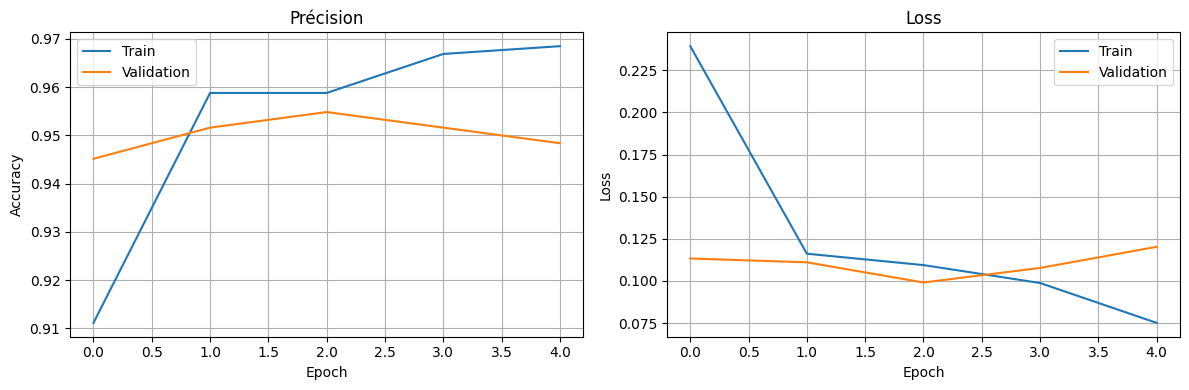

In [ ]:
# Usage
model, history, class_indices = entrainer_modele(
    'flowers_dest',
    num_classes=2,  # Number of classes in your dataset
    epochs= 5
)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

def evaluer_modele(model_path, test_dir, class_indices):
    """Evaluates the model on the test folder and displays several metrics"""
    
    # Load the trained model
    model = load_model(model_path)
    
    # Reverse class_indices to get names from indices
    classes = {v: k for k, v in class_indices.items()}
    
    # Generator to load images from the test set
    # No augmentation, just rescale
    test_datagen = ImageDataGenerator(rescale=1./255)
    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(224, 224),
        batch_size=1,             # batch=1 to predict image by image
        class_mode='categorical',
        shuffle=False             # IMPORTANT to align y_true and y_pred
    )
    
    # Predictions on the entire test set
    print("Predicting on test set...")
    predictions = model.predict(test_generator, verbose=1)
    
    # y_pred = index of the most probable class
    y_pred = np.argmax(predictions, axis=1)
    
    # y_true = true classes provided by the generator
    y_true = test_generator.classes
    
    # Get class names in index order
    class_names = [classes[i] for i in sorted(classes.keys())]
    
    # CLASSIFICATION REPORT 
    print("\n" + "="*60)
    print("CLASSIFICATION REPORT")
    print("="*60)
    print(classification_report(y_true, y_pred, target_names=class_names))
    
    # CONFUSION MATRIX 
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.tight_layout()
    plt.show()
    
    # GLOBAL ACCURACY 
    accuracy = np.sum(y_pred == y_true) / len(y_true)
    print(f"\nGlobal accuracy: {accuracy*100:.2f}%")
    
    # ERROR ANALYSIS 
    print("\n" + "="*60)
    print("ERROR ANALYSIS")
    print("="*60)
    
    errors = []
    # Iterate through each prediction and store the incorrect ones
    for i in range(len(y_true)):
        if y_true[i] != y_pred[i]:
            errors.append({
                'index': i,
                'true': classes[y_true[i]],      # true class name
                'pred': classes[y_pred[i]],      # predicted incorrect class name
                'confidence': predictions[i][y_pred[i]]  # model confidence in its error
            })
    
    print(f"Number of errors: {len(errors)}")
    
    # Display the most "confident" errors (where the model was wrong with high confidence)
    if len(errors) > 0:
        print("\nTop 5 errors with highest confidence:")
        errors_sorted = sorted(errors, key=lambda x: x['confidence'], reverse=True)
        for i, err in enumerate(errors_sorted[:5], 1):
            print(f"{i}. True class: {err['true']}, "
                  f"Predicted: {err['pred']}, "
                  f"Confidence: {err['confidence']*100:.1f}%")
    
    return cm, accuracy, errors


In [24]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix


Found 310 images belonging to 2 classes.
Prédiction sur le test set...
310/310 ━━━━━━━━━━━━━━━━━━━━ 17s 42ms/step

RAPPORT DE CLASSIFICATION
              precision    recall  f1-score   support

       daisy       0.95      0.94      0.95       153
        rose       0.94      0.96      0.95       157

    accuracy                           0.95       310
   macro avg       0.95      0.95      0.95       310
weighted avg       0.95      0.95      0.95       310



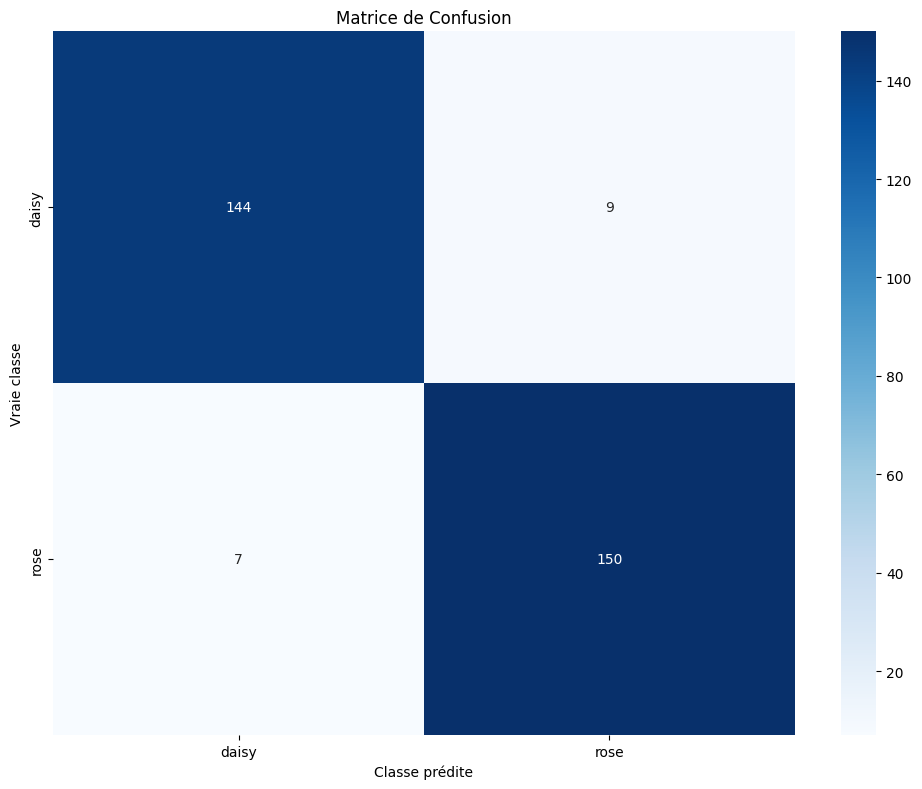


Précision globale: 94.84%

ANALYSE DES ERREURS
Nombre d'erreurs: 16

Top 5 erreurs avec plus haute confiance:
1. Vraie classe: rose, Prédite: daisy, Confiance: 99.3%
2. Vraie classe: rose, Prédite: daisy, Confiance: 96.8%
3. Vraie classe: daisy, Prédite: rose, Confiance: 96.2%
4. Vraie classe: rose, Prédite: daisy, Confiance: 91.0%
5. Vraie classe: daisy, Prédite: rose, Confiance: 87.6%


In [ ]:
# Usage
cm, acc, errors = evaluer_modele(
    'mon_classificateur.h5',
    './flowers_dest/test',
    class_indices
)